## Part - 4 : Fine Tuning a Text To Speech Model.

This notebook demonstrates the complete workflow for fine-tuning a Text-to-Speech (TTS) model using SpeechT5. The goal is to take a pretrained model and adapt it to a new dataset, new speakers, or a new language, which reflects the type of model adaptation required in the assignment.

The notebook walks through all key stages of a TTS fine-tuning pipeline:

1. **Model Setup** – loading the pretrained SpeechT5 TTS model and processor.

2. **Dataset Preparation** – selecting an appropriate speech dataset, normalizing transcripts, resampling audio, and creating clean text–audio pairs suitable for training.

3. **Speaker Embeddings** – extracting x-vectors using a pretrained speaker-recognition model so SpeechT5 can learn multi-speaker conditioning.

4. **Feature Processing** – converting text into input IDs and audio into log-mel spectrograms, which act as the target outputs during training.

5. **Data Collation** – batching variable-length text and spectrogram sequences using a custom collator.

6. **Fine-Tuning** – training SpeechT5 using HuggingFace’s Trainer, logging loss, evaluating on a validation split, and saving checkpoints.

7. **Evaluation & Inference** – generating speech from new text using the fine-tuned model and vocoder to listen to results.

Overall, the notebook provides a self-contained example of how to adapt a pretrained TTS model to a new domain.

### Install required packages

We install Transformers from GitHub since not all the SpeechT5 features we need have been merged into an official release yet.


In [ ]:
!pip install datasets==3.6.0 soundfile speechbrain -q

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install --upgrade accelerate -q

Checking GPU is configured or not. We will Use T4 for this task.

In [ ]:
!nvidia-smi

Wed Nov  5 20:47:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             32W /   70W |    4532MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In case no GPU is found, from the menu choose **Runtime > Change runtime type** and set **Hardware accelerator** to **GPU**. Then restart the runtime to activate the GPU.

## Load the model

We'll start from SpeechT5 that's already been fine-tuned for English TTS, and fine-tune it again but for a new language.

In [ ]:
!pip install huggingface-hub==1.0.1 -q

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

🔐 **Note on Hugging Face Token Access**

When running this notebook, ifyou see a error stating:

“*Notebook does not have secret access: This notebook does not have access to the secret named HF_TOKEN.*”

This appears because the notebook is trying to access the Hugging Face Hub (for downloading models or pushing checkpoints), and your environment needs to have your Hugging Face API token as a secret. I have stored my API key in collab secrets section, I would suggest you can do the same.

If you prefer not to grant access, you can instead manually set your token in the notebook:



```
from huggingface_hub import login

login()  # paste your HF token when prompted
```



This note ensures the notebook runs smoothly while keeping your credentials secure.

### Load the dataset

We'll fine-tune on the Dutch (language code `nl`) examples from VoxPopuli.

VoxPopuli is a large-scale multilingual speech corpus consisting of data sourced from 2009-2020 European Parliament event recordings. It contains labelled audio-transcription data for 15 European languages.

In [ ]:
from datasets import load_dataset, Audio

dataset = load_dataset(
    "facebook/voxpopuli", "nl", split="train", trust_remote_code=True
)

Using the latest cached version of the module from /root/.cache/huggingface/modules/datasets_modules/datasets/facebook--voxpopuli/b5ff837284f0778eefe0f642734e142d8c3f574eba8c9c8a4b13602297f73604 (last modified on Wed Nov  5 19:53:18 2025) since it couldn't be found locally at facebook/voxpopuli, or remotely on the Hugging Face Hub.


It's important to set the sampling rate of the audio data to 16 kHz, which is what SpeechT5 expects.


We resample all audio to **16 kHz** because SpeechT5 was originally trained on data at this exact sampling rate. The model’s feature extractor, mel-spectrogram settings, and the speaker-embedding model (x-vectors) are all designed for 16 kHz audio. If clips come in at different rates like 44.1 kHz or 48 kHz, the timing, frequency scale, and speaker features will no longer match what the model expects. This leads to distorted spectrograms, unstable training, and inconsistent outputs. Converting everything to 16 kHz keeps the audio uniform so the model can learn reliably.



In [ ]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
dataset

Dataset({
    features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
    num_rows: 20968
})

In [ ]:
dataset.cache_files

[{'filename': '/root/.cache/huggingface/datasets/facebook___voxpopuli/nl/1.3.0/b5ff837284f0778eefe0f642734e142d8c3f574eba8c9c8a4b13602297f73604/voxpopuli-train.arrow'}]

This dataset contains around 20k paired text–audio samples, along with metadata such as language, speaker ID, and accent. Each entry provides both the raw transcript and a cleaned “normalized_text,” which is ideal for TTS training. The audio field stores the speech signal, which we later resample and convert into mel-spectrograms for model input.

### Data Cleaning

Some characters in the dataset may not be supported by the SpeechT5 tokenizer. When this happens, the tokenizer replaces them with an `<unk>` (unknown) token, which hurts training.

To avoid this, we check which characters actually appear in the dataset and whether the tokenizer can handle them. The dataset provides both raw_text and normalized_text, and the normalized version is cleaner (lowercase, numbers written out), so we use that.

We then extract all unique characters from the transcripts in one batch, so we can see which ones need to be replaced or cleaned before training.

We write function extract_all_chars that concatenates the transcriptions from all examples into one long transcription and then transforms the string into a set of characters.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
tokenizer = processor.tokenizer

def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/20968 [00:00<?, ? examples/s]

Now we have two sets of characters, one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. By taking the difference between these sets, we find the characters that are in the dataset but not in the tokenizer.

In [ ]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'ç', 'è', 'ë', 'í', 'ï', 'ö', 'ü'}

Next, we will define a function to map these characters to valid tokens and then run it on the dataset. No need to handle space, that's already replaced by `▁` in the tokenizer.

In [ ]:
replacements = [
    ('à', 'a'),
    ('ç', 'c'),
    ('è', 'e'),
    ('ë', 'e'),
    ('í', 'i'),
    ('ï', 'i'),
    ('ö', 'o'),
    ('ü', 'u'),
]

def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text)

### Accounting for Multi-Speakers

VoxPopuli is a multi-speaker dataset. We know there are 20968 examples in the dataset, but how many speakers are there and how many examples do they have?



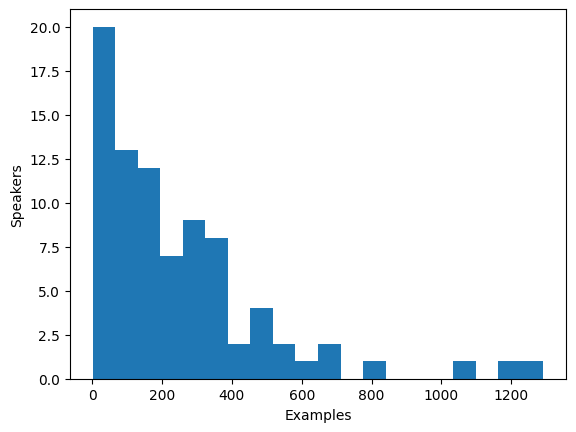

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

Most speakers have very few recordings (under 100), while a small number have several hundred or even more than a thousand. To keep training balanced and avoid one speaker dominating the model, we keep only speakers with a reasonable amount of data—between 100 and 400 examples each. This gives us a cleaner, more uniform multi-speaker dataset for fine-tuning.

In [ ]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400

dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

print(f'Number of speakers: {len(dataset.unique("speaker_id"))}')
print(f'How many samples left after filtering: {len(dataset)}')

Number of speakers: 42
How many samples left after filtering: 9973


### Creating Speaker Embeddings

Since our dataset includes many different speakers, we need a way for the TTS model to know who is speaking in each example. We do this by adding a speaker embedding—a vector that summarizes the unique characteristics of a speaker’s voice. To generate these embeddings, we use the pretrained SpeechBrain model spkrec-xvect-voxceleb, which takes an audio clip and returns a 512-dimensional vector representing that speaker.

In [ ]:
import huggingface_hub as hfh
import os, torch
from speechbrain.pretrained import EncoderClassifier
from huggingface_hub import snapshot_download

try:
    _orig_hf_hub_download = hfh.hf_hub_download
except AttributeError:
    from huggingface_hub.file_download import hf_hub_download as _orig_hf_hub_download

def _compat_hf_hub_download(*args, use_auth_token=None, token=None, **kwargs):
    if token is None and use_auth_token is not None:
        token = use_auth_token
    return _orig_hf_hub_download(*args, token=token, **kwargs)
hfh.hf_hub_download = _compat_hf_hub_download
try:
    import huggingface_hub.file_download as _fd
    _fd.hf_hub_download = _compat_hf_hub_download
except Exception:
    pass

repo_id = "speechbrain/spkrec-xvect-voxceleb"
local_dir = snapshot_download(repo_id)

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=local_dir,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", "sb_xvect_voxceleb"),
)

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/tmp/sb_xvect_voxceleb/hyperparams.yaml'
DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/custom.py' -> '/tmp/sb_xvect_voxceleb/custom.py'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in /tmp/sb_xvect_voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/tmp/sb_xvect_voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /tmp/sb_xvect_voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/tmp/sb_xvect_voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /tmp/sb_xvect_voxcel

In [ ]:
def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

The speaker-embedding model we are using (spkrec-xvect-voxceleb) was trained on English voices.
Our dataset contains Dutch voices.

Speaker-embedding models usually work across languages, because they focus on who is speaking, not what language they are speaking.

In [ ]:
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False)

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])
    return example

processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

prepare_dataset() converts raw text + audio into model-ready features (tokenized text, mel spectrogram, and speaker embedding) for each example.

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

Now, let's run the prepare_dataset() function on every example in the dataset.

In [ ]:
# Calculate the number of rows for half the dataset
half_size = len(dataset) // 2

# Select the first half of the dataset
dataset = dataset.select(range(half_size))

This snippet trims the original dataset to only the first 50% of its rows. It’s useful when you want to perform faster experimentation

In [ ]:
dataset = dataset.map(
    prepare_dataset, remove_columns=dataset.column_names,
)

def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])

### Train/test split



In [ ]:
dataset = dataset.train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 3736
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 416
    })
})

Defining a data collator, This custom data collator prepares each batch before training by padding inputs, aligning audio targets, injecting speaker embeddings, and formatting everything into PyTorch tensors.

In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

data_collator = TTSDataCollatorWithPadding(processor=processor)


## Training the Model

In [ ]:
from transformers import SpeechT5ForTextToSpeech
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)
model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [ ]:
import torch


# Simple configuration without patching
model.config.use_cache = False
if hasattr(model, 'encoder') and hasattr(model.encoder, 'config'):
    model.encoder.config.use_cache = False
if hasattr(model, 'decoder') and hasattr(model.decoder, 'config'):
    model.decoder.config.use_cache = False

model.train()

SpeechT5ForTextToSpeech(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5EncoderWithTextPrenet(
      (prenet): SpeechT5TextEncoderPrenet(
        (embed_tokens): Embedding(81, 768, padding_idx=1)
        (encode_positions): SpeechT5ScaledPositionalEncoding(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (wrapped_encoder): SpeechT5Encoder(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (layers): ModuleList(
          (0-11): 12 x SpeechT5EncoderLayer(
            (attention): SpeechT5Attention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.1, inplace=False)
     

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/PS2_GSP/Part4/speecht5_finetuned_clasp",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_safetensors=True,
    num_train_epochs=50,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,  # Reduced from 16
    learning_rate=1e-4,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    warmup_steps=500,
    fp16=False,  # Try without fp16 first
    gradient_checkpointing=False,  # Try without this first
    max_grad_norm=1.0,
    dataloader_num_workers=0,  # Disable workers
    dataloader_pin_memory=False,
    logging_steps=100,
    report_to=["tensorboard"],
    label_names=["labels"],
    push_to_hub=False,
    use_cache=False,
    remove_unused_columns=False,
)


In [ ]:

from transformers import Seq2SeqTrainer, EarlyStoppingCallback

callbacks = [EarlyStoppingCallback(early_stopping_patience=8)]

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    callbacks=callbacks
)

In [ ]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()


60

In [ ]:

import glob
import os

def _latest_ckpt(path):
    ckpts = glob.glob(os.path.join(path, "checkpoint-*"))
    return max(ckpts, key=os.path.getmtime) if ckpts else None

resume = _latest_ckpt(training_args.output_dir)
trainer.train(resume_from_checkpoint=resume)

Epoch,Training Loss,Validation Loss
1,0.596600,0.509436
2,0.546200,0.496028
3,0.522000,0.485110
4,0.511200,0.473632
5,0.503500,0.472651
6,0.497200,0.474802
7,0.491300,0.471989
8,0.488400,0.468946
9,0.485000,0.470247
10,0.481600,0.468393


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3583: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=8190, training_loss=0.4689005897158668, metrics={'train_runtime': 11538.8672, 'train_samples_per_second': 16.189, 'train_steps_per_second': 1.014, 'total_flos': 1.4810148095209632e+16, 'train_loss': 0.4689005897158668, 'epoch': 35.0})

Let's explicitly disable gradient checkpointing on the model. This might be necessary in addition to setting `gradient_checkpointing=False` in `TrainingArguments` for some model architectures.

## Saving the model to drive

In [ ]:
trainer.save_model(training_args.output_dir)
processor.save_pretrained(training_args.output_dir)

['/content/drive/MyDrive/PS2_GSP/Part4/speecht5_finetuned_clasp/processor_config.json']

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

OUT_DIR = "/content/drive/MyDrive/PS2_GSP/Part4/speecht5_finetuned_clasp"

# save processor into the folder
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
processor.save_pretrained(OUT_DIR)

# now load everything locally
processor = SpeechT5Processor.from_pretrained(OUT_DIR)
model = SpeechT5ForTextToSpeech.from_pretrained(OUT_DIR)
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
print("Loaded model + processor + vocoder.")

Loaded model + processor + vocoder.


## Doing a small sanity Test

In [ ]:
from transformers import SpeechT5ForTextToSpeech, SpeechT5Processor

OUT_DIR = "/content/drive/MyDrive/PS2_GSP/Part4/speecht5_finetuned_clasp"

model = SpeechT5ForTextToSpeech.from_pretrained(OUT_DIR)
processor = SpeechT5Processor.from_pretrained(OUT_DIR)

model.eval()
print("Loaded model!")

Loaded model!


In [ ]:
example = dataset["test"][10]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
speaker_embeddings.shape

torch.Size([1, 512])

In [ ]:
text = input("Enter the text you want to convert to speech: ")
inputs = processor(text=text, return_tensors="pt")
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

with torch.no_grad():
    speech = vocoder(spectrogram)


Enter the text you want to convert to speech: Kunt u wat langzamer praten, alstublieft?


In [ ]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)